In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
import joblib

In [2]:
# Load your dataset
data = pd.read_csv('/content/APL_Logistics_Data_Updated.csv')

<ipython-input-2-38cd27c6655e>:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/APL_Logistics_Data_Updated.csv')


In [3]:
selected_columns = [
    'Planned Base Cost', 'Actual Pickup Month',
    'Actual Pickup Day', 'Actual Pickup Year', 'Actual Delivery Month', 'Actual Delivery Day',
    'Actual Delivery Year', 'Weight Unit of measure (LB)', 'Time Difference (Hours)', 'Average Hourly Wage',
    'Fuel Rate /Gallon', 'Level of Disruption', 'Travel Time'

]

In [4]:
# Filter the data based on selected columns
data_filtered = data[selected_columns]

In [5]:
# Function to convert Travel Time to hours
def convert_to_hours(time_str):
    parts = time_str.split(' ')
    hours = int(parts[0])
    if len(parts) > 2:  # If the time includes minutes
        mins = int(parts[2])
    else:
        mins = 0
    return hours + mins / 60  # Convert minutes to hours

In [6]:
# Convert 'Travel Time' to hours
data_filtered['Travel Time (hours)'] = data_filtered['Travel Time'].apply(convert_to_hours)

# Drop the original 'Travel Time' column
data_filtered.drop('Travel Time', axis=1, inplace=True)

<ipython-input-6-05f121a0353d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Travel Time (hours)'] = data_filtered['Travel Time'].apply(convert_to_hours)
<ipython-input-6-05f121a0353d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.drop('Travel Time', axis=1, inplace=True)


In [7]:
# #One-hot encode categorical columns
# categorical_cols = ['Equipment/Trailer/Container Type', 'Tender Type (Ordinary/Broadcast)']
# data_filtered = pd.get_dummies(data_filtered, columns=categorical_cols)

In [8]:
data_filtered['Travel Time (hours)'].head()

0     5.333333
1    10.783333
2     1.816667
3     4.316667
4     6.816667
Name: Travel Time (hours), dtype: float64

In [9]:
# Function to remove outliers based on the IQR
def remove_outliers(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

# Remove outliers from relevant continuous features
data_filtered = remove_outliers(data_filtered)


In [10]:
data_filtered.shape

(20816, 13)

In [11]:
#Correlation analysis
corr_matrix = data_filtered.corr()
correlation_threshold = 0.2
highly_correlated_cols = (corr_matrix['Planned Base Cost'].abs() > correlation_threshold) | (corr_matrix['Planned Base Cost'].abs() < -correlation_threshold)
selected_columns = highly_correlated_cols[highly_correlated_cols].index.tolist()
selected_columns.remove('Planned Base Cost')  # Remove the target variable from the selected columns
data_selected = data_filtered[selected_columns + ['Planned Base Cost']]

In [12]:
# Define your features and target variable
X = data_filtered.drop('Planned Base Cost', axis=1)
y = data_filtered['Planned Base Cost']

In [13]:
X.head()

,Actual Pickup Month,Actual Pickup Day,Actual Pickup Year,Actual Delivery Month,Actual Delivery Day,Actual Delivery Year,Weight Unit of measure (LB),Time Difference (Hours),Average Hourly Wage,Fuel Rate /Gallon,Level of Disruption,Travel Time (hours)
0,2,13,2024,2,14,2024,24610.00000,32.0,11.11,4.044,0,5.333333
1,2,16,2024,2,19,2024,26455.47144,63.5,11.11,4.044,0,10.783333
2,2,14,2024,2,15,2024,42300.09421,25.0,11.11,4.044,0,1.816667
3,2,12,2024,2,13,2024,3212.00000,34.0,11.11,4.044,0,4.316667
4,2,15,2024,2,16,2024,40662.83122,27.0,11.11,4.044,0,6.816667


In [14]:
# Preprocessing for numerical data: Scaling
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Bundle preprocessing for numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
    ])

# Define the model with Ridge Regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])


In [15]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
X_train.head()

,Actual Pickup Month,Actual Pickup Day,Actual Pickup Year,Actual Delivery Month,Actual Delivery Day,Actual Delivery Year,Weight Unit of measure (LB),Time Difference (Hours),Average Hourly Wage,Fuel Rate /Gallon,Level of Disruption,Travel Time (hours)
15298,7,5,2022,7,8,2022,39592.61922,65.716667,10.97,5.486,1,8.816667
18433,4,14,2022,4,18,2022,26058.63937,97.666667,11.04,5.120,1,7.866667
16322,6,2,2022,6,6,2022,41333.01445,90.983333,10.92,5.754,1,4.033333
10154,12,16,2022,12,20,2022,10303.00000,98.000000,11.01,4.714,0,1.266667
11236,11,7,2022,11,8,2022,40000.00000,27.333333,10.98,5.255,0,8.883333


In [17]:
# Training the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Actual Pickup Month',
                                                   'Actual Pickup Day',
                                                   'Actual Pickup Year',
                                                   'Actual Delivery Month',
                                                   'Actual Delivery Day',
                                                   'Actual Delivery Year',
                                                   'Weight Unit of measure '
                                                   '(LB)',
                                                   'Time Difference (Hours)',
                                                   'Average Hourly Wage',
                                                   'Fuel Rate /Gallon',
                                                   'Level of Disruption',
                                                   'Travel Time (hours)'])])),
                ('regressor', Ridge())])

In [18]:
# Predicting
y_pred = model.predict(X_test)

In [19]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 604985.2892359918
Root Mean Squared Error (RMSE): 777.808002810457
R-squared (R2): 0.43820866452081475


In [20]:
from sklearn.preprocessing import PolynomialFeatures
# Preprocessing for numerical data: Scaling and Polynomial Features
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))  # Add polynomial features
])

In [21]:
# Bundle preprocessing for numerical data
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
    ])

# Define the model with Ridge Regression
model_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('regressor', Ridge(alpha=1.0))
])


In [22]:

model_1.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Actual Pickup Month',
                                                   'Actual Pickup Day',
                                                   'Actual Pickup Year',
                                                   'Actual Delivery Month',
                                                   'Actual Delivery Day',
                                                   'Actual Delivery Year',
                                                   'Weight Unit of measure '
                                                   '(LB)',
                                                   'Time Difference (Hours)',
                                                   'Average Hourly Wage',
                                                   'Fuel Rate /Gallon',
                                                   'Level of Disruption',
                                                   'Travel Time (hours)'])])),
                ('regressor', Ridge())])

In [23]:
# Predicting
y_pred = model_1.predict(X_test)
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [24]:
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 434682.03265061066
Root Mean Squared Error (RMSE): 659.3042034225253
R-squared (R2): 0.5963528304300041


In [25]:
ridge_estimator = model.named_steps['regressor']

# Get the coefficients and intercept of the Ridge model
coefficients = ridge_estimator.coef_
intercept = ridge_estimator.intercept_

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [-2.19078771e+02 -1.93855494e+01 -1.92040493e+02  1.31740758e+02
  1.78890587e+01  6.74230746e-02  9.85021750e+01  2.99665437e+02
 -1.27585822e+02  6.72371176e+00  1.03251705e+01  4.50023276e+02]
Intercept: 1882.3395694210717


In [26]:
# Define additional models
linear_model = LinearRegression()
rf_model = RandomForestRegressor()
mlp_model = MLPRegressor()
svr_model = SVR()

In [27]:
# Define additional pipelines
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', linear_model)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_model)
])

mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', mlp_model)
])

svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', svr_model)
])


In [28]:
# Fit additional models
linear_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
mlp_pipeline.fit(X_train, y_train)
svr_pipeline.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Actual Pickup Month',
                                                   'Actual Pickup Day',
                                                   'Actual Pickup Year',
                                                   'Actual Delivery Month',
                                                   'Actual Delivery Day',
                                                   'Actual Delivery Year',
                                                   'Weight Unit of measure '
                                                   '(LB)',
                                                   'Time Difference (Hours)',
                                                   'Average Hourly Wage',
                                                   'Fuel Rate /Gallon',
                                                   'Level of Disruption',
                                                   'Travel Time (hours)'])])),
                ('regressor', SVR())])

In [29]:
# Evaluate additional models
linear_pred = linear_pipeline.predict(X_test)
rf_pred = rf_pipeline.predict(X_test)
mlp_pred = mlp_pipeline.predict(X_test)
svr_pred = svr_pipeline.predict(X_test)

In [30]:
# Calculate RMSE and R-squared for additional models
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_pred))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))

In [31]:
linear_r2 = r2_score(y_test, linear_pred)
rf_r2 = r2_score(y_test, rf_pred)
mlp_r2 = r2_score(y_test, mlp_pred)
svr_r2 = r2_score(y_test, svr_pred)

In [32]:
# Print the RMSE and R-squared for additional models
print("Linear Regression RMSE:", linear_rmse)
print("Linear Regression R-squared:", linear_r2)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest R-squared:", rf_r2)
print("MLP RMSE:", mlp_rmse)
print("MLP R-squared:", mlp_r2)
print("SVR RMSE:", svr_rmse)
print("SVR R-squared:", svr_r2)

Linear Regression RMSE: 778.5827926185299
Linear Regression R-squared: 0.4370888843436711
Random Forest RMSE: 459.97040132966754
Random Forest R-squared: 0.8035328276903042
MLP RMSE: 764.0033565809946
MLP R-squared: 0.45797320605757597
SVR RMSE: 885.1142450585209
SVR R-squared: 0.27250689259959393


In [33]:
ensemble_model = VotingRegressor([
    ('linear', linear_pipeline),
    ('rf', rf_pipeline),
    ('mlp', mlp_pipeline),
    ('svr', svr_pipeline),
    ('polynomial', model_1)
])


In [34]:
ensemble_model.fit(X_train, y_train)
ensemble_pred = ensemble_model.predict(X_test)

ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_r2 = r2_score(y_test, ensemble_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
# Print the MSE, RMSE, and R-squared for ensemble method
print("Ensemble MSE:", ensemble_mse)
print("Ensemble RMSE:", ensemble_rmse)
print("Ensemble R-squared:", ensemble_r2)

Ensemble MSE: 413267.43967497704
Ensemble RMSE: 642.8588022847451
Ensemble R-squared: 0.616238492115625


In [36]:
ridge_estimator = linear_pipeline.named_steps['regressor']

# Get the coefficients and intercept of the Ridge model
coefficients = ridge_estimator.coef_
intercept = ridge_estimator.intercept_

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [-6.29002835e+03 -4.98227589e+02 -1.55705422e+04  6.21821320e+03
  4.95489413e+02  1.54043440e+04  9.83997474e+01  2.41350132e+02
 -1.28315492e+02  5.61108661e+00  1.17369993e+01  4.51070211e+02]
Intercept: 1882.3395694176359


In [37]:
def get_feature_names_out(column_transformer, input_features=None):
    """Generate the names of the features after transformation."""
    output_features = []

    for name, trans, column, in column_transformer.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            # For transformers with get_feature_names_out method
            if trans.__class__.__name__ == 'PolynomialFeatures':
                feature_names = trans.get_feature_names_out(input_features)
                # Create more descriptive feature names for polynomial features
                feature_names = [name.replace(" ", "_") for name in feature_names]
            else:
                feature_names = trans.get_feature_names_out(column)
        else:
            feature_names = column

        output_features.extend(feature_names)

    return output_features

# Assuming 'numerical_cols' are your original features going into PolynomialFeatures
transformed_feature_names = get_feature_names_out(rf_pipeline.named_steps['preprocessor'], input_features=numerical_cols)

print(transformed_feature_names)

['Actual Pickup Month', 'Actual Pickup Day', 'Actual Pickup Year', 'Actual Delivery Month', 'Actual Delivery Day', 'Actual Delivery Year', 'Weight Unit of measure (LB)', 'Time Difference (Hours)', 'Average Hourly Wage', 'Fuel Rate /Gallon', 'Level of Disruption', 'Travel Time (hours)']


In [38]:
# Define parameter grid for RandomForestRegressor
rf_param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 10, 15],
    'regressor__min_samples_split': [2, 5, 10]
}

# Define parameter grid for MLPRegressor
mlp_param_grid = {
    'regressor__hidden_layer_sizes': [(50,), (100,), (150,)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__alpha': [0.0001, 0.001, 0.01]
}

# Perform grid search for RandomForestRegressor
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Perform grid search for MLPRegressor
mlp_grid_search = GridSearchCV(mlp_pipeline, mlp_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
mlp_grid_search.fit(X_train, y_train)

# Get the best hyperparameters for each model
best_rf_params = rf_grid_search.best_params_
best_mlp_params = mlp_grid_search.best_params_

print("Best RandomForestRegressor Parameters:", best_rf_params)
print("Best MLPRegressor Parameters:", best_mlp_params)


Best RandomForestRegressor Parameters: {'regressor__max_depth': 15, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}
Best MLPRegressor Parameters: {'regressor__activation': 'relu', 'regressor__alpha': 0.01, 'regressor__hidden_layer_sizes': (150,)}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
# Get the best RandomForestRegressor and MLPRegressor models with the best parameters
best_rf_model = rf_grid_search.best_estimator_
best_mlp_model = mlp_grid_search.best_estimator_

# Fit the best RandomForestRegressor model
best_rf_model.fit(X_train, y_train)

# Predict using the best RandomForestRegressor model
rf_pred = best_rf_model.predict(X_test)

# Calculate RMSE and R-squared for the RandomForestRegressor model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("RandomForestRegressor RMSE:", rf_rmse)
print("RandomForestRegressor R-squared:", rf_r2)

# Fit the best MLPRegressor model
best_mlp_model.fit(X_train, y_train)

# Predict using the best MLPRegressor model
mlp_pred = best_mlp_model.predict(X_test)

# Calculate RMSE and R-squared for the MLPRegressor model
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))
mlp_r2 = r2_score(y_test, mlp_pred)

print("MLPRegressor RMSE:", mlp_rmse)
print("MLPRegressor R-squared:", mlp_r2)

RandomForestRegressor RMSE: 461.8339310649399
RandomForestRegressor R-squared: 0.801937663858136
MLPRegressor RMSE: 751.8405163757582
MLPRegressor R-squared: 0.4750938342557329


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [40]:
# Define the StackingRegressor with RandomForestRegressor, MLPRegressor, and Polynomial Regression models
stacked_model = StackingRegressor([
    ('rf', best_rf_model),
    ('mlp', best_mlp_model),
    ('poly', model_1)  # Include your polynomial model here
], final_estimator=Ridge())

# Fit the StackingRegressor model
stacked_model.fit(X_train, y_train)

# Predict using the StackingRegressor model
stacked_pred = stacked_model.predict(X_test)

# Calculate RMSE and R-squared for the StackingRegressor model
stacked_rmse = np.sqrt(mean_squared_error(y_test, stacked_pred))
stacked_r2 = r2_score(y_test, stacked_pred)

print("Stacked Model RMSE:", stacked_rmse)
print("Stacked Model R-squared:", stacked_r2)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Stacked Model RMSE: 462.07432867639835
Stacked Model R-squared: 0.801731416107738


In [41]:
import pandas as pd

# Create a DataFrame with X_test, y_test, and rf_pred
rf_results_df = pd.DataFrame({
    # Add more feature columns as needed
    'Actual Target': y_test,
    'RF Predictions': rf_pred
})

# Display the DataFrame
print(rf_results_df.head())


       Actual Target  RF Predictions
14838        1517.04     1416.048184
13819        2959.99     2748.495715
850          3460.38     3401.342187
3941         2208.00     1292.478406
2264          333.92      921.132008


In [42]:
# Make predictions using the Random Forest regressor on the test data
rf_y_pred = best_rf_model.predict(X_test)

# Combine predicted values with selected columns
predicted_df = pd.DataFrame(data=rf_y_pred, index=X_test.index, columns=['Predicted'])
selected_with_predictions = pd.concat([X_test, predicted_df], axis=1)  # Combine with selected columns

# Forecast future values for the next 12 months for each index
# Assuming the trend in predictions continues for the next 12 months
inflation_rate = 0.032  # 3.2% inflation rate

forecasted_values = {}
for idx in selected_with_predictions.index:
    last_predicted_value = selected_with_predictions.loc[idx, 'Predicted']
    forecasted_values[idx] = []
    for i in range(1, 13):  # Forecast for the next 12 months
        # Adjust the predicted value for inflation
        predicted_value_adjusted = last_predicted_value * (1 + inflation_rate * i)  # Increase by inflation rate each month
        forecasted_values[idx].append(predicted_value_adjusted)

# Convert forecasted values to DataFrame
forecasted_df = pd.DataFrame.from_dict(forecasted_values, orient='index', columns=[f'Month_{i}' for i in range(1, 13)])

# Print the forecasted values adjusted for inflation with month numbers
print("\nForecasted values for the next 12 months adjusted for inflation:")
print(forecasted_df.head(2))


Forecasted values for the next 12 months adjusted for inflation:
           Month_1      Month_2      Month_3      Month_4      Month_5  \
14838  1461.361726  1506.675268  1551.988809  1597.302351  1642.615893   
13819  2836.447578  2924.399441  3012.351304  3100.303167  3188.255030   

           Month_6      Month_7      Month_8      Month_9     Month_10  \
14838  1687.929435  1733.242977  1778.556519  1823.870061  1869.183603   
13819  3276.206893  3364.158756  3452.110618  3540.062481  3628.014344   

          Month_11     Month_12  
14838  1914.497145  1959.810686  
13819  3715.966207  3803.918070  


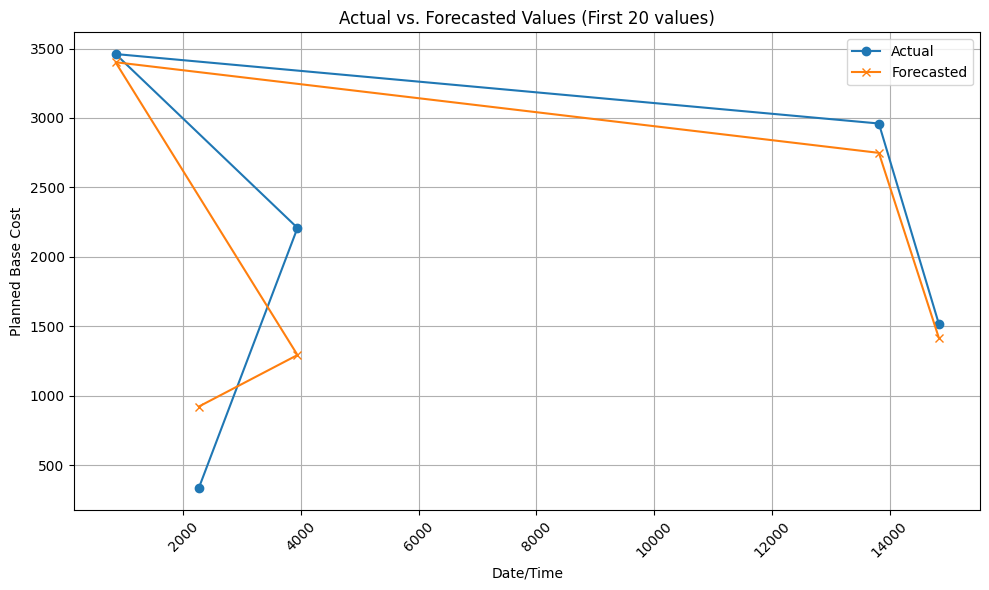

In [43]:
import matplotlib.pyplot as plt

# Plot actual vs. forecasted values for the first 20 values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[:5], y_test[:5], label='Actual', marker='o')
plt.plot(selected_with_predictions.index[:5], selected_with_predictions['Predicted'][:5], label='Forecasted', marker='x')
plt.xlabel('Date/Time')
plt.ylabel('Planned Base Cost')
plt.title('Actual vs. Forecasted Values (First 20 values)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
# Get the RandomForestRegressor model from the pipeline
best_rf_regressor = best_rf_model.named_steps['regressor']

# Get the feature importances from the RandomForestRegressor
feature_importances = best_rf_regressor.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to store feature names and importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature names and importances
print("Features Selected by RandomForestRegressor and their Importances:")
print(feature_importance_df)

Features Selected by RandomForestRegressor and their Importances:
                        Feature  Importance
11          Travel Time (hours)    0.734506
6   Weight Unit of measure (LB)    0.079739
7       Time Difference (Hours)    0.061577
9             Fuel Rate /Gallon    0.029714
8           Average Hourly Wage    0.018684
1             Actual Pickup Day    0.015369
4           Actual Delivery Day    0.014748
5          Actual Delivery Year    0.013939
2            Actual Pickup Year    0.010615
0           Actual Pickup Month    0.009959
3         Actual Delivery Month    0.007214
10          Level of Disruption    0.003937


In [46]:
# Save the best RandomForestRegressor model
best_rf_model = RandomForestRegressor()
best_rf_model.fit(X_train, y_train)
joblib.dump(best_rf_model, 'APL_Logisitcs_Model.joblib')

['APL_Logisitcs_Model.joblib']